In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import StandardScaler
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
import gc
from math import ceil
import tensorflow as tf
import wtte.wtte as wtte
from keras.models import Sequential, load_model,Model
from keras.layers import Dense,LSTM,GRU,Activation,Masking,BatchNormalization,Lambda,Input
from keras import backend as K
from keras import callbacks
from keras.optimizers import RMSprop,adam,Nadam
from keras.callbacks import History, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os
from  more_itertools import ilen
plt.style.use('seaborn-muted')
# # np.random.seed(2)
# # pd.set_option("display.max_rows",1000)
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# path = '../Tax_paper/code/output_files/results/'
# a = os.path.join(path,'suffix_and_remaining_time_helpdesk.csv')
# b = os.path.join(path,'suffix_and_remaining_time_bpi_12_w.csv')
# c = os.path.join(path,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
# d = os.path.join(path,'suffix_and_remaining_time_env_permit.csv')

path = '../Tax_paper/data/'
a = os.path.join(path,'helpdesk.csv')
b = os.path.join(path,'bpi_12_w.csv')
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
d = os.path.join(path,'env_permit.csv')

a = pd.read_csv(a)
b = pd.read_csv(b)
c = pd.read_csv(c)
d = pd.read_csv(d)

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd': d
}
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2)
}

# for key, dataset in df_dict.items():
#     plt.figure(figsize=(10,5))
#     sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"])
#     plt.title(key,fontsize=18)
#     plt.plot()

In [3]:
# baseline = {}
# for dataset in ['a','b','c','d']:
#     tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
#     tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
#     baseline[dataset] = list(tmp.values())
# pickle.dump(baseline, open("baseline.pkl","wb"))

In [6]:
filename = "new_T2E"
mydict = {}
model = None
for key,dataset in df_dict.items():
    mae_list=[]
    print("\ndataset:",key)
    print("\tpreprocessing", end =" ... ")
    dataset_preprocessed = preprocess(dataset)
    print("done")
    for suffix in range_dict[key]:
        print("\t\tsuffix:",suffix)
        print("\t\t\tsuffix splitting", end = " ... ")
        X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed, 
                                                                     train_perc = 0.67,
                                                                     val_perc = 0.20,
                                                                     suffix = suffix,
                                                                     scaling = False)
        print("done")
        print('\t\t\t',len(X_train),len(X_val), len(X_test))
        print("\t\t\tTraining", end =" ........... ")
        model = train(X_train, y_train, X_val, y_val)
        model.load_weights('best_model.h5')
        print("done")
        mae_list.append(evaluating(X_test,y_test,model))
        print("\t\t\tMAE: ",mae_list[-1])
    mydict[key] = mae_list
pickle.dump(mydict, open(filename+".pkl","wb"))


dataset: a
	preprocessing ... done
		suffix: 2
			suffix splitting ... done
			 2684 670 449
			Training ........... done
			MAE:  11.106904231625835
		suffix: 3
			suffix splitting ... done
			 2877 719 207
			Training ........... done
			MAE:  12.21401978197259
		suffix: 4
			suffix splitting ... done
			 2973 743 87
			Training ........... 

KeyboardInterrupt: 

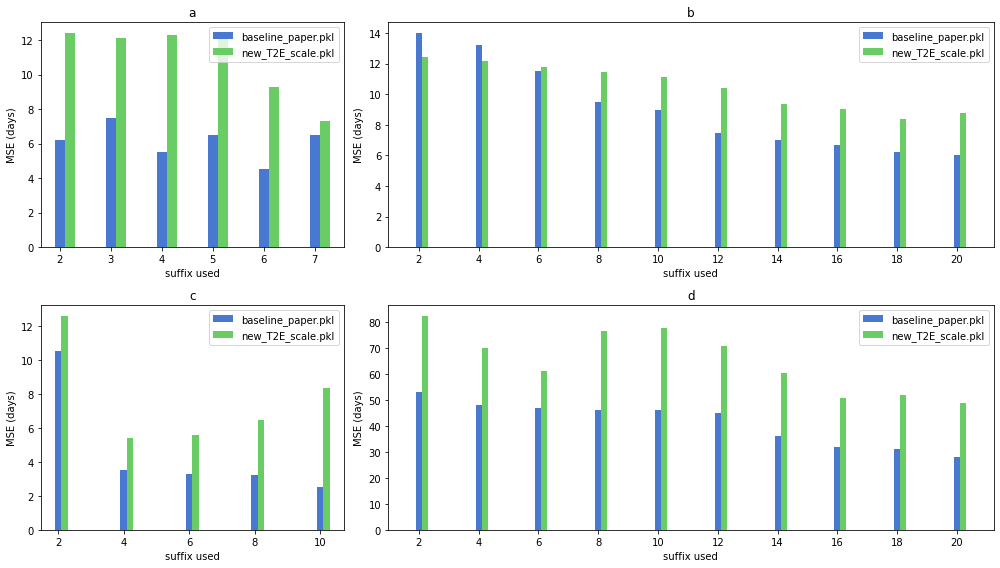

In [5]:
cases = ["baseline_paper.pkl", "new_T2E_scale.pkl"]

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 2]},figsize=(14,8))

for i,dataset in enumerate(['a','b','c','d']):
    if dataset == 'a':
        plt.sca(ax[0][0])
    elif dataset == 'b':
        plt.sca(ax[0][1])
    elif dataset == 'c':
        plt.sca(ax[1][0])
    elif dataset == 'd':
        plt.sca(ax[1][1])

    X = np.array(range_dict[dataset])
    steps = [0, 0.2]
    for j,case in enumerate(cases):
        data = list(pickle.load(open(case,"rb")).values())[i];
        plt.bar(X+steps[j], data, width = 0.2, label=case);
    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
plt.tight_layout()
plt.show()

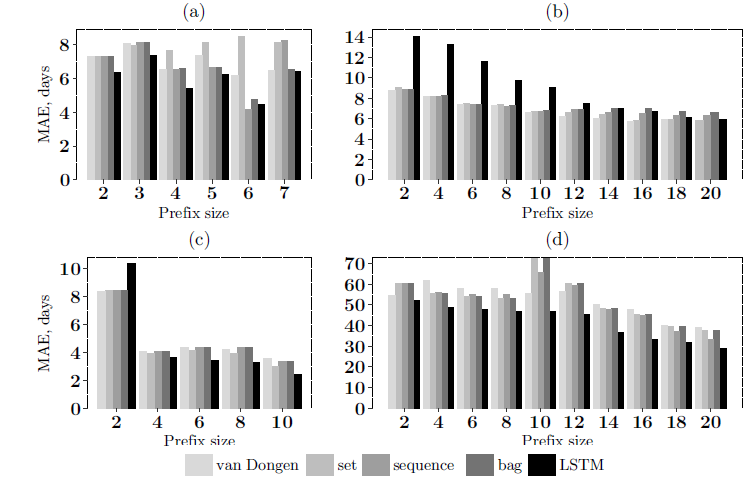

###############################################################################################################################

In [1]:
## Testing

In [183]:
suffix = 5
dataset = df_dict['a']
dataset_preprocessed = preprocess(dataset, suffix+1)

X_train, X_test, X_val, y_train, y_test, y_val = smart_split(dataset_preprocessed,0.67,0.2,suffix,scaling=True)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3009, 5, 11), (3009, 2), (752, 5, 11), (752, 2), (42, 5, 11), (42, 2))

In [198]:
len(y_train) // y_train[:,0].max()

60

In [213]:
num_delete = len(np.squeeze(np.argwhere(y_train[:,0] == 0))) - len(y_train) // y_train[:,0].max()
idx_delete = np.random.choice(np.squeeze(np.argwhere(y_train[:,0]==0)), num_delete, replace=False)
X_train = np.delete(X_train, idx_delete , 0)
y_train = np.delete(y_train, idx_delete , 0)

num_delete = len(np.squeeze(np.argwhere(y_val[:,0] == 0))) - len(y_val) // y_val[:,0].max()
idx_delete = np.random.choice(np.squeeze(np.argwhere(y_val[:,0]==0)), num_delete, replace=False)
X_val = np.delete(X_val, idx_delete , 0)
y_val = np.delete(y_val, idx_delete , 0)

In [214]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((1195, 5, 11), (1195, 2), (298, 5, 11), (298, 2), (42, 5, 11), (42, 2))

In [187]:
# dataset_preprocessed.loc[(dataset_preprocessed["fvt1"] > 16.390277) & (dataset_preprocessed["fvt1"] < 16.390279) ]
# dataset_preprocessed.loc[dataset_preprocessed["CaseID"] == 368]

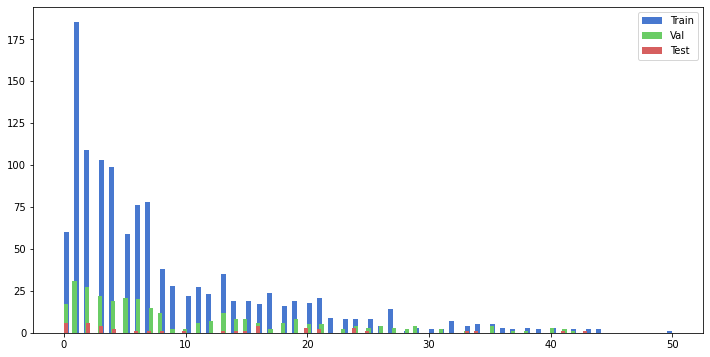

In [215]:
plt.figure(figsize=(12,6))
plt.hist(y_train[:,0], bins = 120,label="Train");
plt.hist(y_val[:,0], bins = 120,label="Val");
plt.hist(y_test[:,0], bins = 120, label="Test");
plt.legend()
plt.show()

In [216]:
print(X_train[0,1,0])
print(X_test[0,1,0])
print(y_train[0])
print(y_test[0])

-100.0
0.0
[2 1]
[41 1]


## Model

In [227]:
from keras.callbacks import CSVLogger

def train_notebook(X_train, y_train, X_val, y_val):
    tte_mean_train = np.nanmean(y_train[:,0].astype('float'))
    mean_u = np.nanmean(y_train[:,1].astype('float'))
    init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
    init_alpha = init_alpha/mean_u
    history = History()
    csv_logger = CSVLogger('training.log', separator=',', append=False)
    n_features = X_train.shape[-1]
    
    main_input = Input(shape=(None, n_features), name='main_input')
#     mask_input = Masking(mask_value=-100, name='mask_input')(main_input)

    l1 = GRU(4, activation='tanh', recurrent_dropout=0.25,return_sequences=False)(main_input)
#     l11 = GRU(10, activation='tanh', recurrent_dropout=0.25,return_sequences=False)(l1)
    b1 = BatchNormalization()(l1)
    l2 = Dense(2, name='Dense')(b1)
    b2 = BatchNormalization()(l2)
    output = Lambda(wtte.output_lambda, arguments={"init_alpha":init_alpha,"max_beta_value":100, "scalefactor":0.5})(b2)
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    loss = wtte.loss(kind='continuous',reduce_loss=False).loss_function
    model = Model(inputs=[main_input], outputs=[output])
    model.compile(loss=loss, optimizer=adam(lr=0.01))
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=True, patience=150, restore_best_weights=True)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=True, save_best_only=True, save_weights_only=True)
    mg_train = batch_gen(X_train, y_train)
    mg_val = batch_gen(X_val, y_val)
    model.fit_generator(mg_train, 
                    epochs=500,
                    steps_per_epoch = ceil(len(X_train) / batch_size),
                    validation_data=(mg_val),
                    validation_steps= ceil(len(X_val) / batch_size),
                    verbose=True,
                    callbacks=[history,es,mc,csv_logger]
                   )
    return model
model = train_notebook(X_train, y_train, X_val, y_val)

Epoch 1/500
10/10 [==============================] - 2s 165ms/step - loss: 2.4291 - val_loss: 2.1173

Epoch 00001: val_loss improved from inf to 2.11728, saving model to best_model.h5
Epoch 2/500
10/10 [==============================] - 0s 9ms/step - loss: 2.2742 - val_loss: 2.1046

Epoch 00002: val_loss improved from 2.11728 to 2.10459, saving model to best_model.h5
Epoch 3/500
10/10 [==============================] - 0s 8ms/step - loss: 2.1995 - val_loss: 2.0957

Epoch 00003: val_loss improved from 2.10459 to 2.09572, saving model to best_model.h5
Epoch 4/500
10/10 [==============================] - 0s 9ms/step - loss: 2.1667 - val_loss: 2.0942

Epoch 00004: val_loss improved from 2.09572 to 2.09417, saving model to best_model.h5
Epoch 5/500
10/10 [==============================] - 0s 8ms/step - loss: 2.1552 - val_loss: 2.0968

Epoch 00005: val_loss did not improve from 2.09417
Epoch 6/500
10/10 [==============================] - 0s 9ms/step - loss: 2.1187 - val_loss: 2.1021

Epoch 0

10/10 [==============================] - 0s 9ms/step - loss: 1.9835 - val_loss: 2.1090

Epoch 00052: val_loss did not improve from 1.98955
Epoch 53/500
10/10 [==============================] - 0s 8ms/step - loss: 1.9916 - val_loss: 2.1273

Epoch 00053: val_loss did not improve from 1.98955
Epoch 54/500
10/10 [==============================] - 0s 10ms/step - loss: 1.9868 - val_loss: 2.0218

Epoch 00054: val_loss did not improve from 1.98955
Epoch 55/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9762 - val_loss: 2.0946

Epoch 00055: val_loss did not improve from 1.98955
Epoch 56/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9724 - val_loss: 2.1063

Epoch 00056: val_loss did not improve from 1.98955
Epoch 57/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9923 - val_loss: 2.0413

Epoch 00057: val_loss did not improve from 1.98955
Epoch 58/500
10/10 [==============================] - 0s 8ms/step - loss: 1.9637 - val_loss: 2.0458


10/10 [==============================] - 0s 9ms/step - loss: 1.9356 - val_loss: 2.1404

Epoch 00106: val_loss did not improve from 1.98955
Epoch 107/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9135 - val_loss: 2.1527

Epoch 00107: val_loss did not improve from 1.98955
Epoch 108/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9248 - val_loss: 2.1335

Epoch 00108: val_loss did not improve from 1.98955
Epoch 109/500
10/10 [==============================] - 0s 8ms/step - loss: 1.9250 - val_loss: 2.1624

Epoch 00109: val_loss did not improve from 1.98955
Epoch 110/500
10/10 [==============================] - 0s 8ms/step - loss: 1.9199 - val_loss: 2.1619

Epoch 00110: val_loss did not improve from 1.98955
Epoch 111/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9284 - val_loss: 2.1354

Epoch 00111: val_loss did not improve from 1.98955
Epoch 112/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9211 - val_loss: 2.


Epoch 00159: val_loss did not improve from 1.98955
Epoch 160/500
10/10 [==============================] - 0s 8ms/step - loss: 1.9196 - val_loss: 2.1793

Epoch 00160: val_loss did not improve from 1.98955
Epoch 161/500
10/10 [==============================] - 0s 10ms/step - loss: 1.8979 - val_loss: 2.1952

Epoch 00161: val_loss did not improve from 1.98955
Epoch 162/500
10/10 [==============================] - 0s 10ms/step - loss: 1.9145 - val_loss: 2.2126

Epoch 00162: val_loss did not improve from 1.98955
Epoch 163/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9119 - val_loss: 2.1929

Epoch 00163: val_loss did not improve from 1.98955
Epoch 164/500
10/10 [==============================] - 0s 10ms/step - loss: 1.9043 - val_loss: 2.2078

Epoch 00164: val_loss did not improve from 1.98955
Epoch 165/500
10/10 [==============================] - 0s 9ms/step - loss: 1.9033 - val_loss: 2.1995

Epoch 00165: val_loss did not improve from 1.98955
Epoch 166/500
10/10 [======

12.145932855191548


,T,U,alpha,beta,predicted_mode,error,abs_error,Accurate
0,41,1,9.65724,0.706345,0.0,41,41,False
1,8,1,9.43834,0.911766,0.0,8,8,False
2,0,1,6.89767,0.45166,0.0,0,0,True
3,0,1,6.17383,0.522646,0.0,0,0,True
4,3,1,9.93417,0.891811,0.0,3,3,False


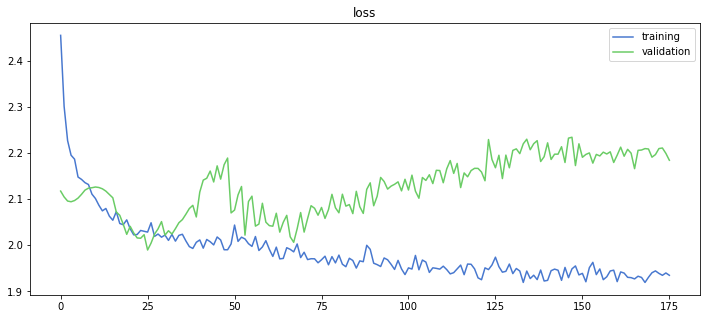

In [228]:
model.load_weights('best_model.h5')
history = pd.read_csv('training.log', sep=',', engine='python')

test_result_df, mae = evaluating(X_test,y_test, model)
print(mae)
plt.figure(figsize = (12,5));
plt.plot(history['loss'], label='training');
plt.plot(history['val_loss'],label='validation');
plt.title('loss');
plt.legend();
test_result_df.head()

In [ ]:
# plt.figure(figsize=(15,8))
# plt.hist(report_train["T"], bins = 120,label="True")
# plt.hist(report_train["predicted_mode"], bins = 120,label="pred_mode")
# plt.legend()
# plt.show()

No handles with labels found to put in legend.


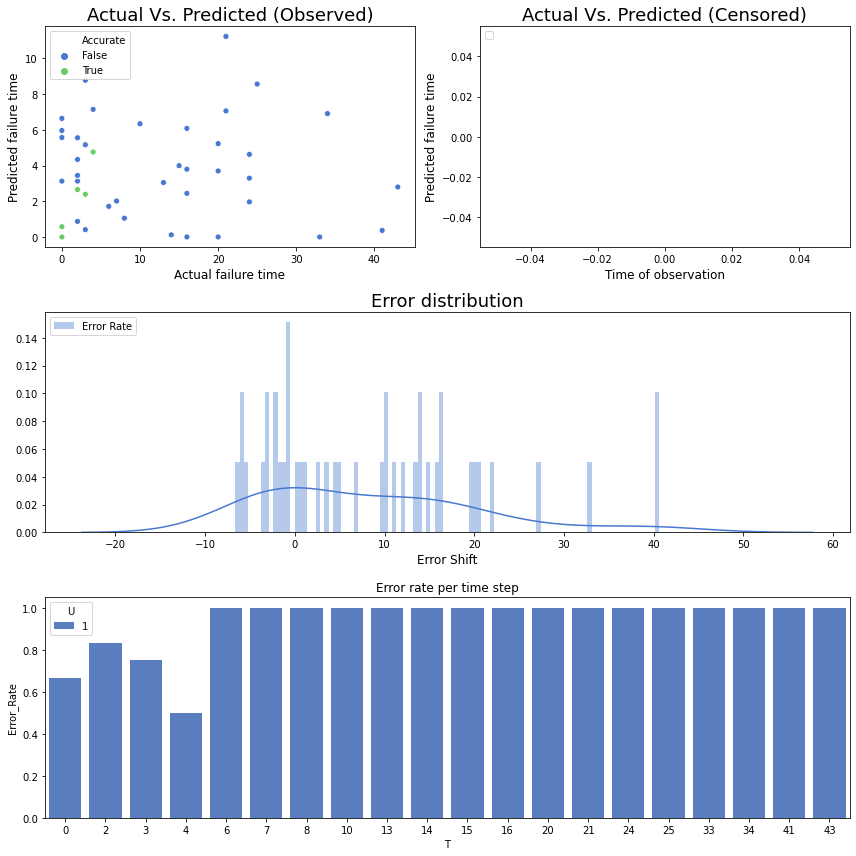

In [219]:
plot_predictions_insights(test_result_df)

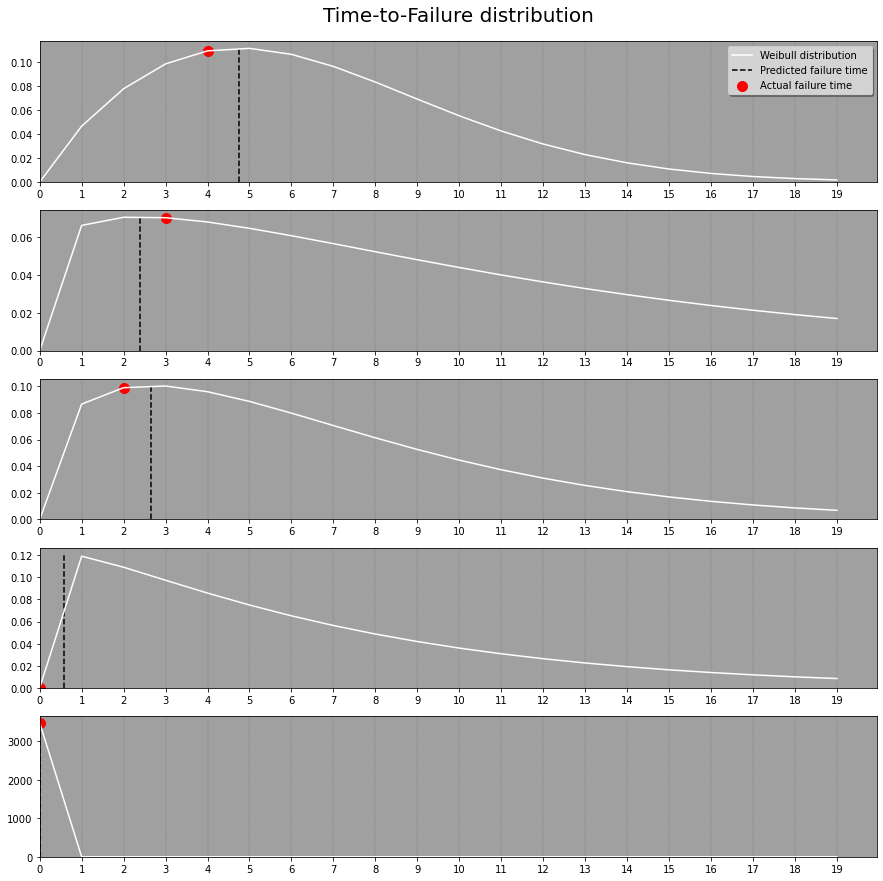

In [220]:
from t2e_utils import *
plot_top_predictions(test_result_df,15,top_feature="T",ascending=False, U=1,accurate=True)